In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 12 2024

@author: Yaning
Data from Ben
Data file name: intertemporal_choice_dataset_all_trials.csv
"""
# functions for simulating agent data
# this file address is your own
%run Documents/pyro_models/files_to_run/data_analysis_without_version.ipynb

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats 


['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


In [2]:
run_data = data.reshape(60, 170, 8)

In [3]:
run_data.shape

(60, 170, 8)

In [4]:
run_data = torch.tensor(run_data)

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/random.py:157: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


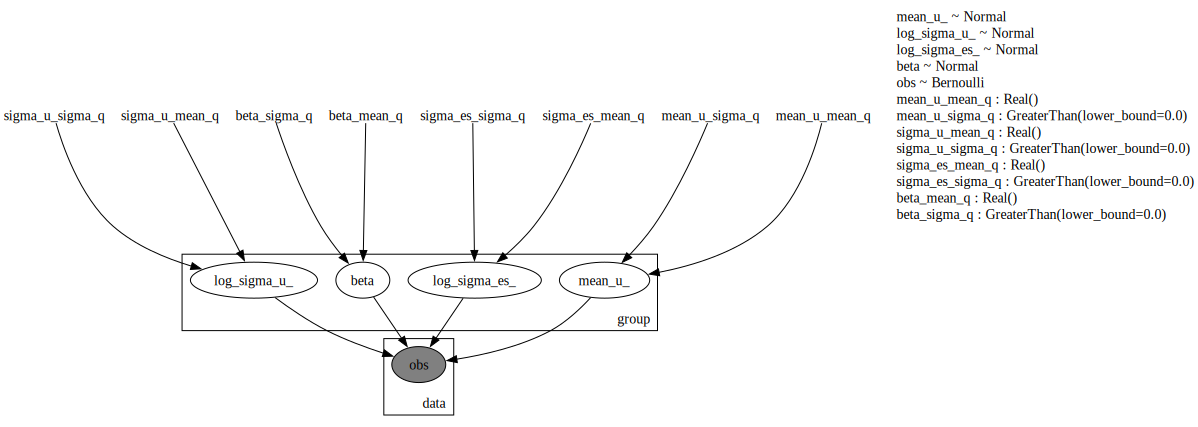

In [5]:
# model
def model_normal_log(data):
    num_groups = data.shape[0]
    num_trials_per_group = data.shape[1]
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.randn(num_groups))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_u_mean_q =  pyro.param("sigma_u_mean_q", torch.randn(num_groups))
    sigma_u_sigma_q =  pyro.param("sigma_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_es_mean_q = pyro.param("sigma_es_mean_q", torch.randn(num_groups))
    sigma_es_sigma_q = pyro.param("sigma_es_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    beta_mean_q = pyro.param("beta_mean_q", torch.randn(num_groups))
    beta_sigma_q = pyro.param("beta_sigma_q", torch.ones(num_groups), constraint=constraints.positive)

    # get individual samples
    with pyro.plate("group", num_groups):
        mean_u = pyro.sample("mean_u_", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
        log_sigma_u = pyro.sample("log_sigma_u_", Normal(loc=sigma_u_mean_q, scale = sigma_u_sigma_q))
        log_sigma_es = pyro.sample("log_sigma_es_", Normal(loc=sigma_es_mean_q, scale = sigma_es_sigma_q))
        beta = pyro.sample("beta", Normal(loc=beta_mean_q, scale = beta_sigma_q))
    
    # loop through all the data with group indices
    with pyro.plate("data", num_groups*num_trials_per_group):
        group_indices = torch.arange(num_groups).unsqueeze(1).repeat(1, num_trials_per_group).reshape(-1)

        sigma_u = torch.exp(log_sigma_u[group_indices])
        sigma_es = torch.exp(log_sigma_es[group_indices])
        e_val = (mean_u[group_indices]*data[:,:,2].view(-1)*sigma_es**2 + 
                 data[:,:,3].view(-1)*sigma_u**2)/(data[:,:,2].view(-1)*sigma_es**2 + sigma_u**2)


        softmax_args = torch.stack([beta[group_indices]*e_val, beta[group_indices]*data[:,:,1].view(-1)])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs", Bernoulli(probs = p), obs=data[:,:,4].view(-1))


def guide_normal_log(data):
    num_groups = data.shape[0]
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.randn(num_groups))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_u_mean_q =  pyro.param("sigma_u_mean_q", torch.randn(num_groups))
    sigma_u_sigma_q =  pyro.param("sigma_u_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    sigma_es_mean_q = pyro.param("sigma_es_mean_q", torch.randn(num_groups))
    sigma_es_sigma_q = pyro.param("sigma_es_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    beta_mean_q = pyro.param("beta_mean_q", torch.randn(num_groups))
    beta_sigma_q = pyro.param("beta_sigma_q", torch.ones(num_groups), constraint=constraints.positive)
    
    # get individual samples
    with pyro.plate("group", data.shape[0]):
        mean_u = pyro.sample("mean_u_", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
        log_sigma_u = pyro.sample("log_sigma_u_", Normal(loc=sigma_u_mean_q, scale = sigma_u_sigma_q))
        log_sigma_es = pyro.sample("log_sigma_es_", Normal(loc=sigma_es_mean_q, scale = sigma_es_sigma_q))
        beta = pyro.sample("beta", Normal(loc=beta_mean_q, scale = beta_sigma_q))

pyro.render_model(model = model_normal_log, model_args=(run_data,), render_params=True, render_distributions=True)

Mean ELBO 3021.63: 100%|████████████████████████████████████████| 1000/1000 [01:02<00:00, 16.11it/s]


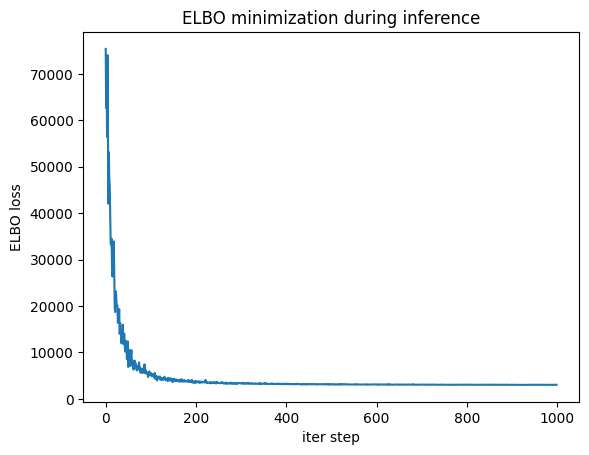

In [6]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 1000

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model_normal_log, guide_normal_log, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(run_data)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [8]:
post_dict = {}
for name, value in pyro.get_param_store().items():
    post_dict[name] = pyro.param(name)
    # print(name, pyro.param(name))

In [10]:
post_dict

dict_keys(['mean_u_mean_q', 'mean_u_sigma_q', 'sigma_u_mean_q', 'sigma_u_sigma_q', 'sigma_es_mean_q', 'sigma_es_sigma_q', 'beta_mean_q', 'beta_sigma_q'])

In [12]:
import pickle
numpy_dict = {key: value.detach().numpy() for key, value in post_dict.items()}
with open('Documents/pyro_models/files_to_run/results/separated.pkl', 'wb') as f:
    pickle.dump(numpy_dict, f)